# Estimating traffic flow using LTE path loss features

Armin Catovic <armin.catovic@ericsson.com>, Kasper Silverforsen <kasper.silverforsen@ericsson.com>

#### Abstract
As the demand for vehicles continues to outpace construction of new roads, it becomes imperative we implement strategies that improve utilization of existing road infrastructure. Insights from traffic flow sensors form a crucial part of such strategy. Due to cost and lead time associated with installation and maintenance of these sensors, municipalities and traffic authorities look toward cheaper and more scalable alternatives. In this project we present a method for traffic flow estimation using inherently anonymous LTE/4G radio frequency counters. The problem is cast as a supervised regression task where our feature variables are LTE path loss counters, and our target variables are vehicle counts. We show promising results, and a potential pathway to significantly cheaper, highly scalable, and privacy-preserving alternative to dedicated traffic sensors.

**Keywords:** *Traffic flow, Radio frequency, Path loss, Machine learning, Regression, LTE*

## 1. Introduction
Traffic flow sensor technology forms a key component of intelligent transportation systems (ITS). Traffic sensors can be categorized as in-roadway (e.g. inductive loop sensors and magnetometers), or over-roadway (e.g. traffic cameras, radar, infrared and laser sensors). More recently there has been a surge of ad-hoc over-roadway sensor technology, including road-side cellular network masts, Bluetooth and Wi-Fi sensors, as well as telemetry collected from connected vehicles, smartphones and GPS devices. Cellular network masts are particularly appealing, combining ubiquity of cellular network technology (e.g. LTE or more specifically E-UTRA), with strict high availability requirements.

While there have been previous works \[1\]-\[7\] in utilizing cellular networks for understanding traffic flow, they've either been intrusive, or not practical from network operations perspective. In this project we present a novel method for traffic flow estimation that leverages standard LTE/E-UTRA performance management (PM) counters, as defined by the 3rd Generation Partnership Project (3GPP) \[8\]. Namely, we utilize path loss distribution counters aggregated over 15 minute intervals. The main reasoning here is that different number of vehicles, i.e. obstacles on the road, can be represented by different path loss distributions. By optimizing for the number of vehicles, i.e. ground truth labels, the model should be able to discriminate between vehicles and all other users undergoing attenuation and losses.

## 2. Method
The dataset consists of vehicle counts (target variables) from laser-beam traffic detectors, and uplink path loss distibution values (feature variables) from an LTE mast. The data is collected from a single location in Stockholm city, see figure below:

![Physical Layout](https://raw.githubusercontent.com/acatovic/kth-traffic-counter/main/data/setup.png)

The distance between the LTE mast and the traffic sensors is ~ 450m, which is less than optimal, however the LTE antenna is on a much higher elevation compared to the measured road, with a clear line-of-sight (LOS), and there is negligible traffic in the close vicinity of the antenna.

Our approach is as follows: we first perform unsupervised/exploratory data analysis (EDA) on both target and feature variables; we then create additional time features and train and test a baseline regression model using just the time features - we are motivated here by the fact that the traffic pattern on this particular road exhibits strong seasonality; we then fit and evaluate a regression model using all the path loss features; in the subsequent sections we perform various path loss feature selection techniques and re-train and re-evaluate our models.

For evaluation purposes we use coefficient of determination or "R squared", referred to as r2 in this project. r2 can be defined as follows:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

where $SS_{tot} = \sum_i (y_i - \bar{y})^2$ represents total sum of squares, and $SS_{res} = \sum_i (y_i - \hat{y_i})^2$ represents residual sum of squares ($\bar{y}$ and $\hat{y_i}$ are the observed data mean and the predicted value respectively). A model that always predicts observed data mean will have a r2 of 0; models with observations worse than the observed data mean will have negative values; the most optimal value for r2 is 1.0, so we want our models to be as close to 1.0 as possible.

## 3. Results

In [1]:
# imports

from collections import defaultdict
import datetime as dt
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import xgboost

from utils import cost_hata_distance, groupby_band, groupby_stationid, ts_train_test_split

### 3.1 Exploratory data analysis

In this section we examine the target and feature variables. The target variables consist of vehicle counts sampled in 15-min intervals from two over-roadway traffic sensors - one sensor captures in-bound and one out-bound traffic. We deal with missing target values - sometimes one of the sensors malfunctions - and we more closely examine the behaviour of traffic over time. Later we create some additional time features to help with model creation.

Feature variables consist of uplink path loss values (in dB) as reported by the LTE/4G radio base station (RBS). The RBS estimates the amount of attenuation from users signal every transmit time interval (TTI), which is 1ms in LTE, and places the estimated value in one of the discretized path loss bins - there are 21 bins in total, ranging from <50dB to >140dB. The path loss features are then aggregated in 15-min intervals. Since feature data is only available for August and September, we use these two months as our dataset. Here we also deal with some missing feature values.

In [2]:
# load target data
d_targets = pd.read_csv('https://raw.githubusercontent.com/acatovic/kth-traffic-counter/main/data/targets.csv')
print(d_targets)

                 StartTime  StationId  NumberOfVehicles
0      2020-04-01 00:00:00        101                28
1      2020-04-01 00:00:00        102                44
2      2020-04-01 00:15:00        102                40
3      2020-04-01 00:15:00        101                22
4      2020-04-01 00:30:00        101                15
...                    ...        ...               ...
34799  2020-09-30 23:15:00        101                52
34800  2020-09-30 23:30:00        102                89
34801  2020-09-30 23:30:00        101                43
34802  2020-09-30 23:45:00        102                68
34803  2020-09-30 23:45:00        101                64

[34804 rows x 3 columns]


In [3]:
print(d_targets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34804 entries, 0 to 34803
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StartTime         34804 non-null  object
 1   StationId         34804 non-null  int64 
 2   NumberOfVehicles  34804 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 815.8+ KB
None


In [4]:
print(d_targets['StationId'].unique())

[101 102]


There are two traffic sensors/stations as expected - one for inbound and one for outbound traffic.

In [5]:
print('StationId 101 # of samples: ', len(d_targets[d_targets['StationId'] == 101]))
print('StationId 102 # of samples: ', len(d_targets[d_targets['StationId'] == 102]))

StationId 101 # of samples:  17386
StationId 102 # of samples:  17418


Number of samples from each StationId are not the same; this is not desirable since in some cases we will not have the "full" picture of the traffic flow - we should drop these data samples.

In [6]:
# we use a helper function to (1) remove time samples where only
# one of the sensors is working, and (2) sum up vehicle counts
# from both sensors
d_targets = groupby_stationid(d_targets)
d_targets = d_targets.set_index('StartTime') # we'll work with time as index from now on
print(d_targets)

                     NumberOfVehicles
StartTime                            
2020-04-01 00:00:00              72.0
2020-04-01 00:15:00              62.0
2020-04-01 00:30:00              49.0
2020-04-01 00:45:00              41.0
2020-04-01 01:00:00              46.0
...                               ...
2020-09-30 22:45:00             215.0
2020-09-30 23:00:00             159.0
2020-09-30 23:15:00             148.0
2020-09-30 23:30:00             132.0
2020-09-30 23:45:00             132.0

[17305 rows x 1 columns]


In [7]:
print(d_targets.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17305 entries, 2020-04-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NumberOfVehicles  17305 non-null  float64
dtypes: float64(1)
memory usage: 270.4 KB
None


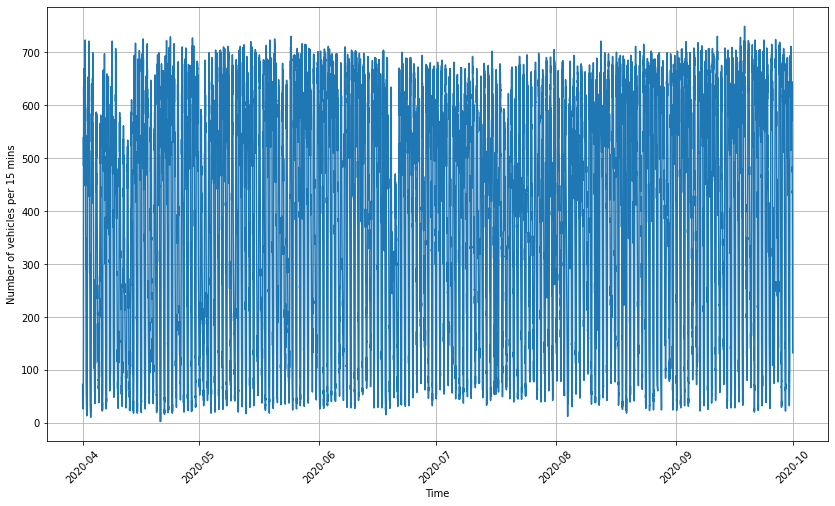

In [8]:
# We can plot the number of vehicles over time
plt.figure(figsize=(14, 8))
plt.plot(d_targets)
plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Number of vehicles per 15 mins')
plt.show()

We see a large drop in traffic flow mid-June - we suspect that may be due to midsummer holiday - we can take a closer look.

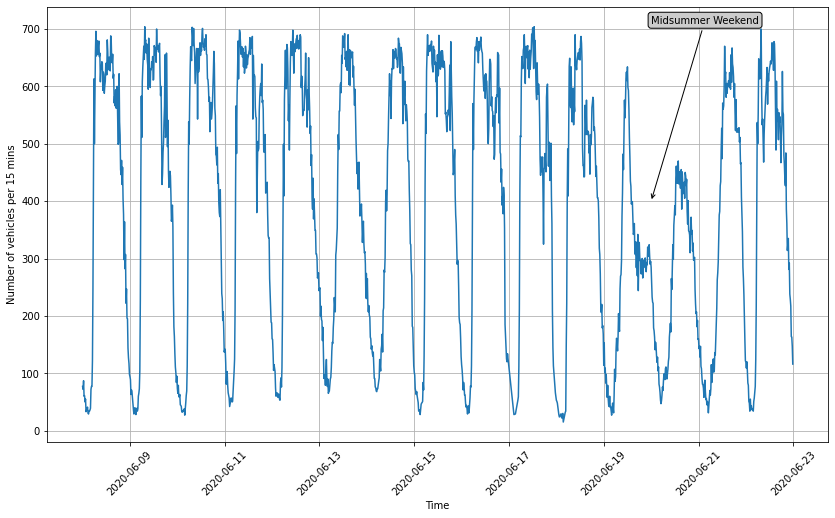

In [9]:
x = md.date2num(dt.datetime(2020, 6, 20))
bbox = {'boxstyle': 'round', 'fc': '0.8'}
arrowprops = {'arrowstyle': '->'}

plt.figure(figsize=(14, 8))
plt.plot(d_targets.loc['2020-06-08':'2020-06-22'])
plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Number of vehicles per 15 mins')
plt.annotate('Midsummer Weekend', xy=(x, 400), xytext=(x, 710), 
            bbox=bbox, arrowprops=arrowprops)
plt.show()

The drop in number of vehicles is due to "midsommar" public holiday in Sweden; this year midsommar fell on Saturday (20/6), which meant that Friday (19/6) was a designated red day - so we see around noon on Friday a significant drop in traffic, and also significantly less traffic on the following day.

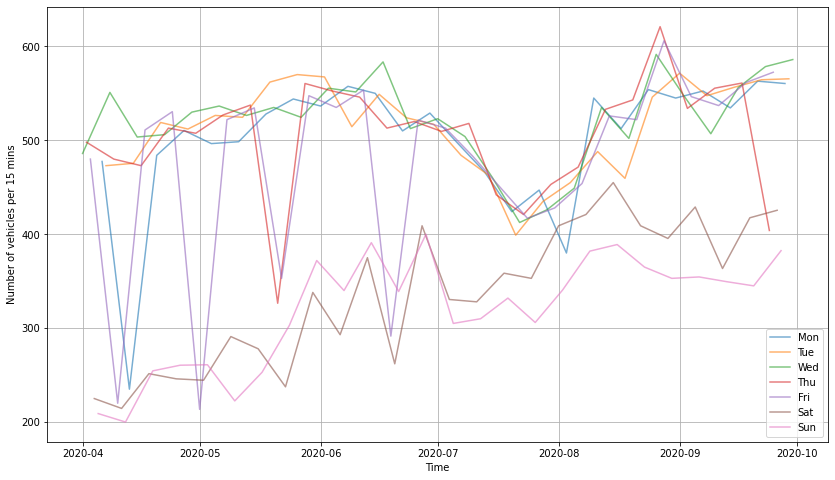

In [10]:
# let's examine for any differences in weekday vs weekend traffic;
# we expect to see some differences here
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(14, 8))
for ix, day in enumerate(days):
    plt.plot(d_targets[d_targets.index.weekday == ix]['NumberOfVehicles']
             .resample('D').median().dropna(), label=day, alpha=.6)
plt.xlabel('Time')
plt.ylabel('Number of vehicles per 15 mins')
plt.grid()
plt.legend()
plt.show()

We can see that the median weekend traffic is lower than median weekday traffic - using features to distinguish weekend/weekday would probably help in any traffic flow estimation model.

In [11]:
# load feature data
d = pd.read_csv('https://raw.githubusercontent.com/acatovic/kth-traffic-counter/main/data/features.csv')
print(d)

                 StartTime  Band  CellId  PL_00  PL_01  PL_02  PL_03  PL_04  \
0      2020-08-01 00:00:00  2600      20    0.0    0.0    0.0    0.0    0.0   
1      2020-08-01 00:00:00  1800      21    0.0    0.0    0.0    0.0    0.0   
2      2020-08-01 00:00:00   800      22    0.0    0.0    0.0    0.0    0.0   
3      2020-08-01 00:00:00  1800      24    0.0    0.0    0.0    0.0    0.0   
4      2020-08-01 00:15:00  2600      20    0.0    0.0    0.0    0.0    0.0   
...                    ...   ...     ...    ...    ...    ...    ...    ...   
23411  2020-09-30 23:30:00  1800      24    0.0    0.0    0.0    0.0    0.0   
23412  2020-09-30 23:45:00  2600      20    0.0    0.0    0.0    0.0    0.0   
23413  2020-09-30 23:45:00  1800      21    0.0    0.0    0.0    0.0    0.0   
23414  2020-09-30 23:45:00   800      22    0.0    0.0    0.0    0.0    2.0   
23415  2020-09-30 23:45:00  1800      24    0.0    0.0    0.0    0.0    0.0   

       PL_05  PL_06  ...    PL_11     PL_12    PL_1

In [12]:
print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23416 entries, 0 to 23415
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   StartTime  23416 non-null  object 
 1   Band       23416 non-null  int64  
 2   CellId     23416 non-null  int64  
 3   PL_00      23408 non-null  float64
 4   PL_01      23408 non-null  float64
 5   PL_02      23408 non-null  float64
 6   PL_03      23408 non-null  float64
 7   PL_04      23408 non-null  float64
 8   PL_05      23408 non-null  float64
 9   PL_06      23408 non-null  float64
 10  PL_07      23408 non-null  float64
 11  PL_08      23408 non-null  float64
 12  PL_09      23408 non-null  float64
 13  PL_10      23408 non-null  float64
 14  PL_11      23408 non-null  float64
 15  PL_12      23408 non-null  float64
 16  PL_13      23408 non-null  float64
 17  PL_14      23408 non-null  float64
 18  PL_15      23408 non-null  float64
 19  PL_16      23408 non-null  float64
 20  PL_17 

In [13]:
# we have some NaN values, let's have a look
print(d[d.isna().any(axis=1)])

                 StartTime  Band  CellId  PL_00  PL_01  PL_02  PL_03  PL_04  \
15132  2020-09-09 09:45:00  2600      20    NaN    NaN    NaN    NaN    NaN   
15133  2020-09-09 09:45:00  1800      21    NaN    NaN    NaN    NaN    NaN   
15134  2020-09-09 09:45:00   800      22    NaN    NaN    NaN    NaN    NaN   
15135  2020-09-09 09:45:00  1800      24    NaN    NaN    NaN    NaN    NaN   
21168  2020-09-25 03:30:00  2600      20    NaN    NaN    NaN    NaN    NaN   
21169  2020-09-25 03:30:00  1800      21    NaN    NaN    NaN    NaN    NaN   
21170  2020-09-25 03:30:00   800      22    NaN    NaN    NaN    NaN    NaN   
21171  2020-09-25 03:30:00  1800      24    NaN    NaN    NaN    NaN    NaN   

       PL_05  PL_06  ...  PL_11  PL_12  PL_13  PL_14  PL_15  PL_16  PL_17  \
15132    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
15133    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
15134    NaN    NaN  ...    NaN    NaN    NaN    NaN    N

In [14]:
# it's just two 15-min sample periods that are missing values;
# we'll remove these
d = d.dropna()
print(d.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23408 entries, 0 to 23415
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   StartTime  23408 non-null  object 
 1   Band       23408 non-null  int64  
 2   CellId     23408 non-null  int64  
 3   PL_00      23408 non-null  float64
 4   PL_01      23408 non-null  float64
 5   PL_02      23408 non-null  float64
 6   PL_03      23408 non-null  float64
 7   PL_04      23408 non-null  float64
 8   PL_05      23408 non-null  float64
 9   PL_06      23408 non-null  float64
 10  PL_07      23408 non-null  float64
 11  PL_08      23408 non-null  float64
 12  PL_09      23408 non-null  float64
 13  PL_10      23408 non-null  float64
 14  PL_11      23408 non-null  float64
 15  PL_12      23408 non-null  float64
 16  PL_13      23408 non-null  float64
 17  PL_14      23408 non-null  float64
 18  PL_15      23408 non-null  float64
 19  PL_16      23408 non-null  float64
 20  PL_17 

In [15]:
cells = d['CellId'].unique()
print('Cells: ', cells)
bands = d['Band'].unique()
print('Carrier frequencies (MHz): ', bands)

Cells:  [20 21 22 24]
Carrier frequencies (MHz):  [2600 1800  800]


In [16]:
# Each 15-min sample period consists of path loss values
# on each cell; one cell is on 2600MHz band, one on 800MHz,
# and two cells are on 1800MHz; we'll group all the values
# by band - this will come in handy later when doing feature
# selection
d = groupby_band(d)
d = d.set_index('StartTime')
print(d)

                     PL_00|800  PL_00|1800  PL_00|2600  PL_01|800  PL_01|1800  \
StartTime                                                                       
2020-08-01 00:00:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:15:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:30:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:45:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 01:00:00        0.0         0.0         0.0        0.0         0.0   
...                        ...         ...         ...        ...         ...   
2020-09-30 22:45:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:00:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:15:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:30:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:45:00        0

In [17]:
print(d.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5852 entries, 2020-08-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PL_00|800   5852 non-null   float64
 1   PL_00|1800  5852 non-null   float64
 2   PL_00|2600  5852 non-null   float64
 3   PL_01|800   5852 non-null   float64
 4   PL_01|1800  5852 non-null   float64
 5   PL_01|2600  5852 non-null   float64
 6   PL_02|800   5852 non-null   float64
 7   PL_02|1800  5852 non-null   float64
 8   PL_02|2600  5852 non-null   float64
 9   PL_03|800   5852 non-null   float64
 10  PL_03|1800  5852 non-null   float64
 11  PL_03|2600  5852 non-null   float64
 12  PL_04|800   5852 non-null   float64
 13  PL_04|1800  5852 non-null   float64
 14  PL_04|2600  5852 non-null   float64
 15  PL_05|800   5852 non-null   float64
 16  PL_05|1800  5852 non-null   float64
 17  PL_05|2600  5852 non-null   float64
 18  PL_06|800   5852 non-null   floa

In [18]:
# Path loss feature are only available for August and September;
# target values are available from April through September; we'll
# combine these into a single dataframe and automatically collapse
# to just August + September
d['NumberOfVehicles'] = d_targets['NumberOfVehicles']
print(d)

                     PL_00|800  PL_00|1800  PL_00|2600  PL_01|800  PL_01|1800  \
StartTime                                                                       
2020-08-01 00:00:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:15:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:30:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:45:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 01:00:00        0.0         0.0         0.0        0.0         0.0   
...                        ...         ...         ...        ...         ...   
2020-09-30 22:45:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:00:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:15:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:30:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:45:00        0

In [19]:
print(d.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5852 entries, 2020-08-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PL_00|800         5852 non-null   float64
 1   PL_00|1800        5852 non-null   float64
 2   PL_00|2600        5852 non-null   float64
 3   PL_01|800         5852 non-null   float64
 4   PL_01|1800        5852 non-null   float64
 5   PL_01|2600        5852 non-null   float64
 6   PL_02|800         5852 non-null   float64
 7   PL_02|1800        5852 non-null   float64
 8   PL_02|2600        5852 non-null   float64
 9   PL_03|800         5852 non-null   float64
 10  PL_03|1800        5852 non-null   float64
 11  PL_03|2600        5852 non-null   float64
 12  PL_04|800         5852 non-null   float64
 13  PL_04|1800        5852 non-null   float64
 14  PL_04|2600        5852 non-null   float64
 15  PL_05|800         5852 non-null   float64
 16  PL_05|

In [20]:
# some target values seem to be missing in August + September range
# so we'll drop those rows
d = d.dropna()
print(d.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5743 entries, 2020-08-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PL_00|800         5743 non-null   float64
 1   PL_00|1800        5743 non-null   float64
 2   PL_00|2600        5743 non-null   float64
 3   PL_01|800         5743 non-null   float64
 4   PL_01|1800        5743 non-null   float64
 5   PL_01|2600        5743 non-null   float64
 6   PL_02|800         5743 non-null   float64
 7   PL_02|1800        5743 non-null   float64
 8   PL_02|2600        5743 non-null   float64
 9   PL_03|800         5743 non-null   float64
 10  PL_03|1800        5743 non-null   float64
 11  PL_03|2600        5743 non-null   float64
 12  PL_04|800         5743 non-null   float64
 13  PL_04|1800        5743 non-null   float64
 14  PL_04|2600        5743 non-null   float64
 15  PL_05|800         5743 non-null   float64
 16  PL_05|

In [21]:
# create cyclic time features and encode weekends; 
# we'll use these features to create a baseline model
# for estimating traffic flow without any path loss data,
# i.e. using just the time features
minutes_in_day = 24. * 60
minutes = d.index.hour * 60 + d.index.minute
d['SinTime'] = np.sin(2. * np.pi * minutes / minutes_in_day)
d['CosTime'] = np.cos(2. * np.pi * minutes / minutes_in_day)
d['isWeekend'] = (d.index.weekday > 4).astype(int)
print(d)

                     PL_00|800  PL_00|1800  PL_00|2600  PL_01|800  PL_01|1800  \
StartTime                                                                       
2020-08-01 00:00:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:15:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:30:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 00:45:00        0.0         0.0         0.0        0.0         0.0   
2020-08-01 01:00:00        0.0         0.0         0.0        0.0         0.0   
...                        ...         ...         ...        ...         ...   
2020-09-30 22:45:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:00:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:15:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:30:00        0.0         0.0         0.0        0.0         0.0   
2020-09-30 23:45:00        0

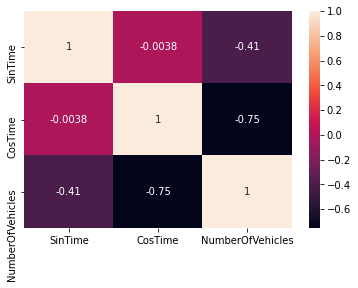

In [22]:
# we can see fairly strong linear correlation between sin/cos time features
# and number of vehicles
sns.heatmap(d[['SinTime', 'CosTime', 'NumberOfVehicles']].corr(), annot=True)
plt.show()

### 3.2 Model selection and evaluation

In this section we train and evaluate different models. We start with a baseline model using only the time features, i.e. time-of-day and weekend indicator variables. We represent time-of-day in terms of cyclic time features as it's more appropriate for regression setting. We then train and test a set of models using all path loss features indiscriminantly. We then proceed by using more elaborate path loss feature selection to see how it compares against baseline models.

In [23]:
# define our X and y for baseline mode
X = d[['SinTime', 'CosTime', 'isWeekend']]
y = d['NumberOfVehicles']

In [24]:
# train/test split
# first 6 weeks for train, last ~2 weeks for test
train_range = ('2020-08-01', '2020-09-13')
test_range = ('2020-09-14', '2020-09-30')
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, train_range, test_range)
print('# of days in train set: ', int(len(X_train) / 96.))
print('# of days in test set: ', int(len(X_test) / 96.))

# of days in train set:  43
# of days in test set:  16


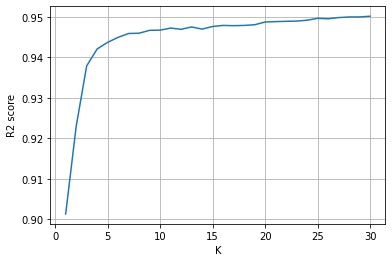

In [25]:
# train a kNN baseline model
Ks = range(1, 31)
R2s = []
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    R2s.append(neigh.fit(X_train, y_train).score(X_test, y_test))

plt.plot(Ks, R2s)
plt.xlabel('K')
plt.ylabel('R2 score')
plt.grid()
plt.show()

In [26]:
# we saw in the previous graph that the elbow (optimal value for k) is
# around k=5
k = 5
neigh = KNeighborsRegressor(n_neighbors=k)
predicted = neigh.fit(X_train, y_train).predict(X_test)
print('*** KNeighborsRegressor (K={}), Time-Features Only ***'.format(k))
print('R2  = ', r2_score(y_test, predicted))

*** KNeighborsRegressor (K=5), Time-Features Only ***
R2  =  0.9436636626360997


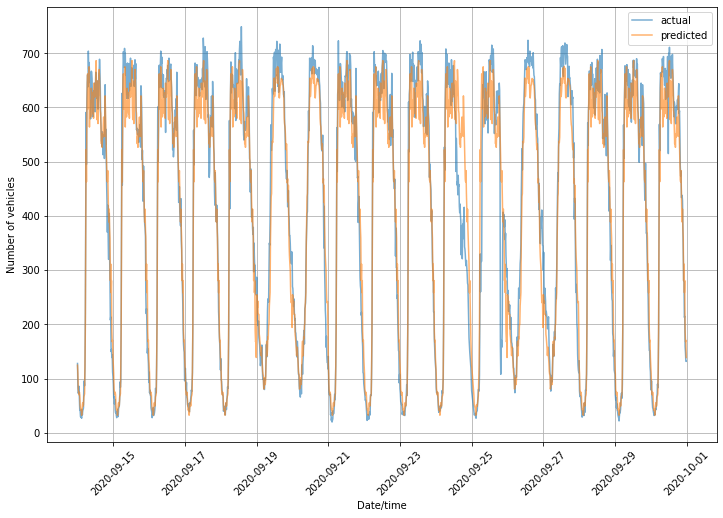

In [27]:
# we see that just using time features for this particular road
# segment, we can build a fairly accurate traffic flow estimator
res = y_test.copy().reset_index().rename(columns={'NumberOfVehicles':'Actual'})
res['Predicted'] = predicted
res = res.set_index('StartTime')

plt.figure(figsize=(12, 8))
plt.plot(res['Actual'], label='actual', alpha=0.6)
plt.plot(res['Predicted'], label='predicted', alpha=0.6)
plt.legend()
plt.grid()
plt.xlabel('Date/time')
plt.xticks(rotation=45)
plt.ylabel('Number of vehicles')
plt.show()

In [28]:
# let's now build some naive models using ALL path loss features;
# first we define our train/test sets; we'll keep all results in one
# dataframe
X = d[d.columns[:63]]
y = d['NumberOfVehicles']
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, train_range, test_range)
res = y_test.copy().reset_index().rename(columns={'NumberOfVehicles':'Actual'})

In [29]:
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

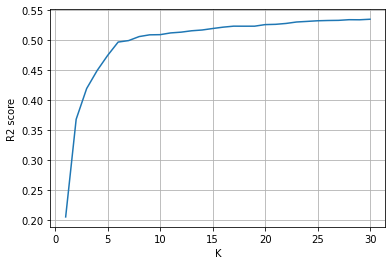

In [30]:
# train a kNN model, find optimal k
Ks = range(1, 31)
R2s = []
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    R2s.append(r2_score(y_test, neigh.predict(X_test)))

plt.plot(Ks, R2s)
plt.xlabel('K')
plt.ylabel('R2 score')
plt.grid()
plt.show()

In [31]:
# based on the elbow above, optimal k is around 6;
# fit a KNN model and get predictions on test data
k = 6
neigh = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
res['PredictedKNN'] = neigh.predict(X_test)

In [32]:
# fit and test a linear regression model using all path loss features
lr = LinearRegression().fit(X_train, y_train)
res['PredictedLR'] = lr.predict(X_test)

In [33]:
# fit and test a xgb model; use "count:poisson" as objective function 
# since we're dealing with integer counts
xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(X_train, y_train)
res['PredictedXGB'] = xgb.predict(X_test)

In [34]:
res = res.set_index('StartTime')
print(res)

                     Actual  PredictedKNN  PredictedLR  PredictedXGB
StartTime                                                           
2020-09-14 00:00:00   128.0    143.666667   273.861311    125.736801
2020-09-14 00:15:00    84.0    113.166667   262.188056    128.345383
2020-09-14 00:30:00    73.0    148.166667   245.331788    157.504410
2020-09-14 00:45:00    75.0    119.333333   239.362250     75.111313
2020-09-14 01:00:00    86.0    111.000000   238.883301    108.022614
...                     ...           ...          ...           ...
2020-09-30 22:45:00   215.0    466.666667   585.430523    447.279541
2020-09-30 23:00:00   159.0    574.166667   555.161867    300.088593
2020-09-30 23:15:00   148.0    570.500000   490.963021    385.997742
2020-09-30 23:30:00   132.0    475.000000   470.885744    303.870422
2020-09-30 23:45:00   132.0    416.333333   471.714061    273.474518

[1614 rows x 4 columns]


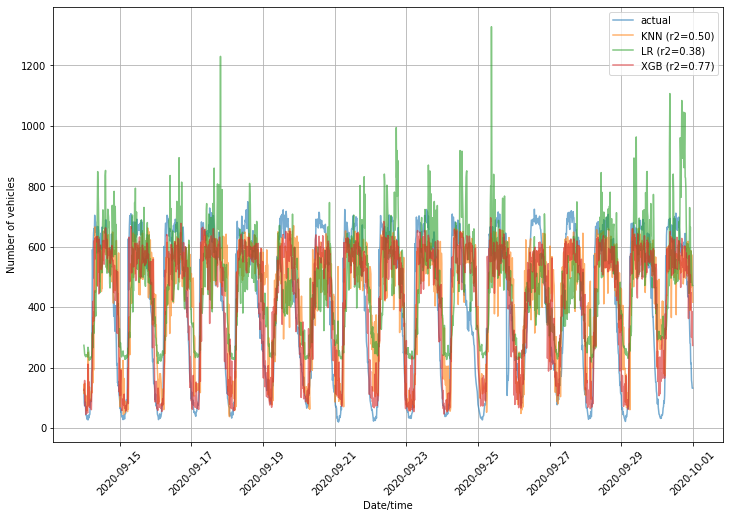

In [35]:
# Plot the traffic flow estimates against actual values, for each of the
# models above; show r2 score for each set of predictions
plt.figure(figsize=(12, 8))
plt.plot(res['Actual'], label='actual', alpha=0.6)
plt.plot(res['PredictedKNN'], label='KNN (r2={:.2f})'.format(
    r2_score(y_test, res['PredictedKNN'])), alpha=0.6)
plt.plot(res['PredictedLR'], label='LR (r2={:.2f})'.format(
    r2_score(y_test, res['PredictedLR'])), alpha=0.6)
plt.plot(res['PredictedXGB'], label='XGB (r2={:.2f})'.format(
    r2_score(y_test, res['PredictedXGB'])), alpha=0.6)
plt.legend()
plt.grid()
plt.xlabel('Date/time')
plt.xticks(rotation=45)
plt.ylabel('Number of vehicles')
plt.show()

We can see that XGBoost gives by far the best performance with r2 score of 0.77. We'll use this algorithm from now on, but with more focus on feature selection.

Instead of using all path loss bins indiscrimnantly, we can apply a scientific approach, and use a radio propagation model to see which path loss bins/features are most appropriate, given the distance between LTE antenna and road, as well as the frequency bands. We can use a COST Hata model \[9\] as defined below:

#### $$L_b = 46.3 + 33.9 log_{10}\frac{f}{MHz} - 13.82 log_{10}\frac{h_B}{m} - \alpha(h_R,f)+\big(44.9 - 6.55 log_{10}\frac{h_B}{m}\big)log_{10}\frac{d}{km}+C_m$$
#### $$log_{10}(\frac{d}{km}) =\frac{(L_b  - 46.3 - 33.9 log_{10}\frac{f}{MHz} + 13.82 log_{10}\frac{h_B}{m} + \alpha(h_R,f))-C_m}{\big(44.9 - 6.55 log_{10}\frac{h_B}{m}\big)}$$

Where 
- $L_b$ = Median path loss in dB
- $f$ = Frequency of Transmission. (MHz)
- $h_B$ = Base station antenna effective height (m)
- $d$ = Link distance (what we want)
- $h_R$ = Mobile station antenna effective height (m) 
- $\alpha(h_R,f) = 3.2(log_{10}(11.75h_R))^2 - 4.97$ : Mobile station antenna height correction factor as described in Hata model for urban areas.
- $C_m$ = 0 dB for medium cities

Note that COST Hata is a very rough approximation - there are much better models out there but they are more complex, requiring more information about the environment and surroundings. For the purposes of this project we will stick to COST Hata only.

In [36]:
# define path loss dB bins as per:
# https://raw.githubusercontent.com/acatovic/kth-traffic-counter/main/data/INFO.txt
dBs = {
    'PL_00':50,
    'PL_01':55,
    'PL_02':60,
    'PL_03':65,
    'PL_04':70,
    'PL_05':75,
    'PL_06':80,
    'PL_07':85,
    'PL_08':90,
    'PL_09':95,
    'PL_10':100,
    'PL_11':105,
    'PL_12':110,
    'PL_13':115,
    'PL_14':120,
    'PL_15':125,
    'PL_16':130,
    'PL_17':135,
    'PL_18':140,
    'PL_19':145,
    'PL_20':150,
}

In [37]:
# Estimate distances based on different path loss (dB) values;
# we'll use our own cost_data_distance() helper function
hB = 37. # estimated LTE tower height (based on Google Street View)
hR = 1.8 # expected height of mobile phone user
Cm = 0. # offset constant used in COST Hata model for typical European city
dBs_df = pd.DataFrame()
band_l = []
pl_l = []
d_l = []
for band in bands:
    for k, v in dBs.items():
        distance = cost_hata_distance(L=v, f=band, hB=hB, hR=hR, Cm=Cm)
        pl_l.append(k)
        d_l.append(distance)
        band_l.append(band)
dBs_df['band'] = band_l
dBs_df['PL'] = pl_l
dBs_df['distance'] = d_l
print(dBs_df)

    band     PL     distance
0   2600  PL_00     2.560642
1   2600  PL_01     3.570587
2   2600  PL_02     4.978864
3   2600  PL_03     6.942580
4   2600  PL_04     9.680807
..   ...    ...          ...
58   800  PL_16  1658.506704
59   800  PL_17  2312.639243
60   800  PL_18  3224.768556
61   800  PL_19  4496.651291
62   800  PL_20  6270.177994

[63 rows x 3 columns]


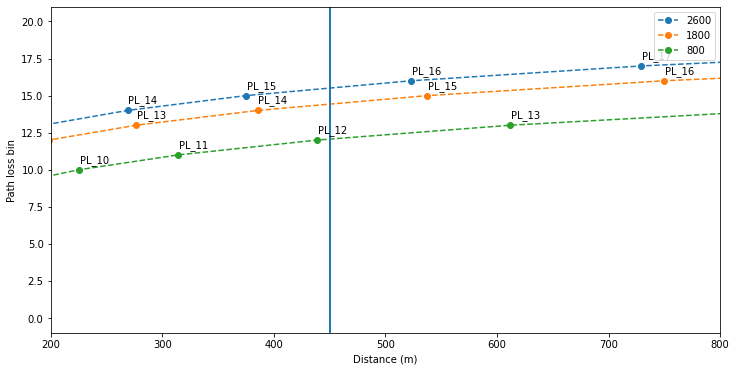

In [38]:
D = 450 # distance between LTE tower and road segment is 450m
features = dBs_df['PL'].unique()
bins = np.arange(len(features))

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
for band in bands:
    distances = dBs_df[dBs_df['band'] == band]['distance'].to_numpy()
    ax.plot(distances, bins, 'o--', label=str(band))
    ax.axvline(x=D, linestyle='-')
    ax.set_xlim(200, 800)
    for i, txt in enumerate(features):
        x_txt = distances[i]
        if x_txt >= 200 and x_txt <= 800:
            ax.text(distances[i]+0.5, bins[i]+0.5, txt)

plt.xlabel('Distance (m)')
plt.ylabel('Path loss bin')
plt.legend()
plt.show()

In [39]:
# Using COST Hata model, we can see that for the distance of 
# 450m, which is the separation between LTE mast and our road 
# of interest, the top 5 path loss features are PL_12 on band
# 800MHz, PL_14 and PL_15 on 1800MHz band, and PL_15 and PL_16 
# on 2600MHz band
hata_top_5_features = ['PL_12|800', 'PL_14|1800', 'PL_15|1800', 'PL_15|2600', 'PL_16|2600']

We can compare our top 5 features selected using COST Hata, against feature selection done using statistical methods. Here we use KBest with chi2 scoring function, and Sequential Feature Selector (SFS) with XGBoost classifier and r2 scoring function. In reality this would not be very practical, since we would always require corresponding ground truth data (number of vehicles from nearby traffic ensors), and that defeats the purpose of our project - we want to use LTE towers in places where there are no existing/functioning traffic sensors.

In [40]:
# select top 5 features using KBest/chi2
kbest = SelectKBest(chi2, k=5).fit(X, y)
kbest_top_5_features = X.columns[kbest.get_support()]
print(kbest_top_5_features)

Index(['PL_06|1800', 'PL_11|800', 'PL_12|800', 'PL_12|1800', 'PL_13|1800'], dtype='object')


In [41]:
# select top 5 features using SFS and XGB
xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson')
sfs = SFS(xgb, k_features=5, forward=True, floating=False, verbose=2, 
          scoring=make_scorer(r2_score)).fit(X, y)
sfs_xgb_top_5_features = list(sfs.k_feature_names_)
print(sfs_xgb_top_5_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  2.2min finished

[2020-12-16 09:56:55] Features: 1/5 -- score: 0.521097221414618[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:  3.8min finished

[2020-12-16 10:00:42] Features: 2/5 -- score: 0.6470582903686419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  3.7min finished

[2020-12-16 10:04:25] Features: 3/5 -- score: 0.6820632722504506[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 o

['PL_05|800', 'PL_09|2600', 'PL_10|800', 'PL_10|1800', 'PL_17|2600']


[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:  4.3min finished

[2020-12-16 10:14:38] Features: 5/5 -- score: 0.7223100005202858

We can see that the selected path loss bins/features vary quite a bit between the three methods.

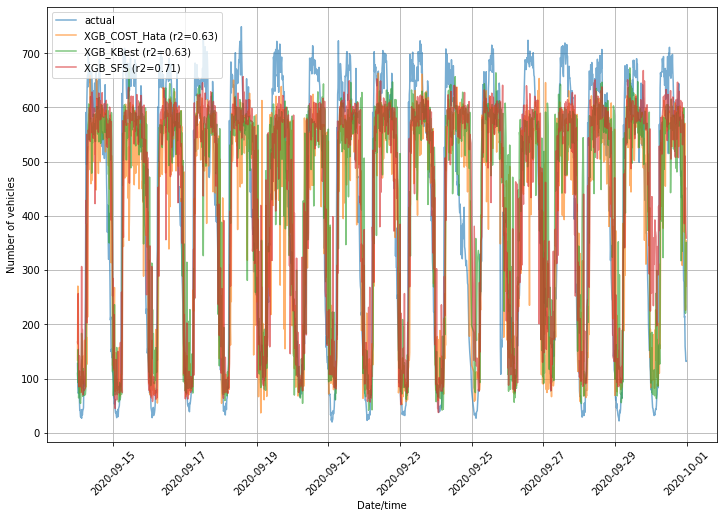

In [42]:
res = y_test.copy().reset_index().rename(columns={'NumberOfVehicles':'Actual'})

hata_indexes = [X.columns.get_loc(c) for c in hata_top_5_features]
xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
    X_train[:, hata_indexes], y_train)
res['XGB_COST_Hata'] = xgb.predict(X_test[:, hata_indexes])

kbest_indexes = [X.columns.get_loc(c) for c in kbest_top_5_features]
xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
    X_train[:, kbest_indexes], y_train)
res['XGB_KBest'] = xgb.predict(X_test[:, kbest_indexes])

sfs_indexes = [X.columns.get_loc(c) for c in sfs_xgb_top_5_features]
xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
    X_train[:, sfs_indexes], y_train)
res['XGB_SFS'] = xgb.predict(X_test[:, sfs_indexes])

res = res.set_index('StartTime')

# Plot the traffic flow estimates against actual values, for each of the
# features selected above; use XGBoost as the fitting algorithm;
# show r2 score for each set of predictions
plt.figure(figsize=(12, 8))
plt.plot(res['Actual'], label='actual', alpha=0.6)
plt.plot(res['XGB_COST_Hata'], label='XGB_COST_Hata (r2={:.2f})'.format(
    r2_score(y_test, res['XGB_COST_Hata'])), alpha=0.6)
plt.plot(res['XGB_KBest'], label='XGB_KBest (r2={:.2f})'.format(
    r2_score(y_test, res['XGB_KBest'])), alpha=0.6)
plt.plot(res['XGB_SFS'], label='XGB_SFS (r2={:.2f})'.format(
    r2_score(y_test, res['XGB_SFS'])), alpha=0.6)
plt.legend()
plt.grid()
plt.xlabel('Date/time')
plt.xticks(rotation=45)
plt.ylabel('Number of vehicles')
plt.show()

We can see that the accuracy of our traffic flow estimates decreases quite significantly when we only select a small subset (in this case, 5) of path loss features - quite clearly there is traffic related information spread out in the other path loss bins as well. Radio wave scattering and diffraction is a complex phenomena, so this is quite expected. Visually inspecting our traffic estimates we can see that we are unable to capture the peaks nor the troughs.

We now select features by considering path loss values in previous time steps. In this case we'll consider the last 96 time steps, corresponding to the last 24 hours, i.e. 96 * 15min. We will do this only for path loss bins that have been selected by our three methods above. We then train the models and run predictions as an ensemble method. Namely, for each path loss bin, we use the previous 96 values as our features and run them through our model to get a traffic flow estimate; we do this for each of the selected path loss bins; we then take the mean value of all the estimates, and compare against the actual value.

In [47]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, train_range, test_range)

time_shift_df_dict = defaultdict(dict)
num_timesteps = 96
for col in X_train.columns:
    train_one_col = X_train[[col]]
    test_one_col = X_test[[col]]
    train_one_col.columns = ['t']
    test_one_col.columns = ['t']
    for t in range(1, num_timesteps):
        train_one_col['t-{}'.format(t)] = train_one_col['t'].shift(t)
        test_one_col['t-{}'.format(t)] = test_one_col['t'].shift(t)
    train_one_col['y'] = y_train
    test_one_col['y'] = y_test
    time_shift_df_dict[col]['train'] = train_one_col.iloc[num_timesteps:, :]
    time_shift_df_dict[col]['test'] = test_one_col.iloc[num_timesteps:, :]

/home/earmcat/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/earmcat/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


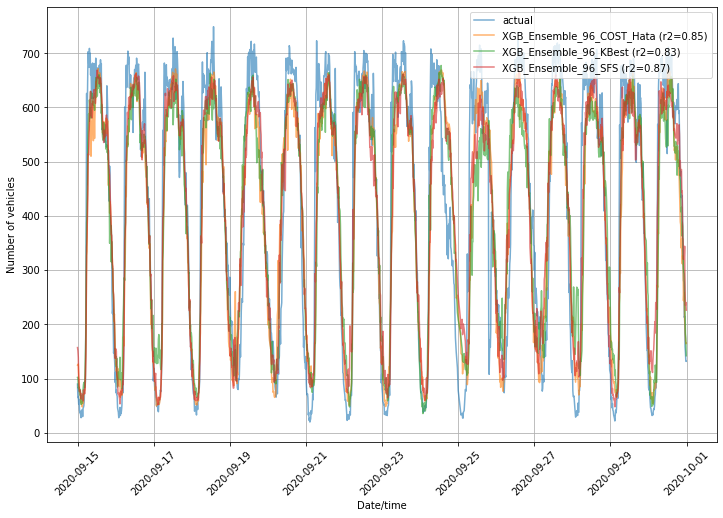

In [48]:
y_test = time_shift_df_dict['PL_10|800']['test']['y']
n_test_samples = len(y_test)

predicted_hata = np.zeros(n_test_samples)
for col in hata_top_5_features:
    X_train_col = time_shift_df_dict[col]['train']
    y_train_col = X_train_col['y']
    X_train_col = X_train_col.drop('y', axis=1)
    X_test_col = time_shift_df_dict[col]['test']
    y_test_col = X_test_col['y']
    X_test_col = X_test_col.drop('y', axis=1)
    xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
        X_train_col, y_train_col)
    predicted_hata += xgb.predict(X_test_col)

predicted_kbest = np.zeros(n_test_samples)
for col in kbest_top_5_features:
    X_train_col = time_shift_df_dict[col]['train']
    y_train_col = X_train_col['y']
    X_train_col = X_train_col.drop('y', axis=1)
    X_test_col = time_shift_df_dict[col]['test']
    y_test_col = X_test_col['y']
    X_test_col = X_test_col.drop('y', axis=1)
    xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
        X_train_col, y_train_col)
    predicted_kbest += xgb.predict(X_test_col)

predicted_sfs = np.zeros(n_test_samples)
for col in sfs_xgb_top_5_features:
    X_train_col = time_shift_df_dict[col]['train']
    y_train_col = X_train_col['y']
    X_train_col = X_train_col.drop('y', axis=1)
    X_test_col = time_shift_df_dict[col]['test']
    y_test_col = X_test_col['y']
    X_test_col = X_test_col.drop('y', axis=1)
    xgb = xgboost.XGBRegressor(seed=42, objective='count:poisson').fit(
        X_train_col, y_train_col)
    predicted_sfs += xgb.predict(X_test_col)

res = y_test.copy().reset_index().rename(columns={'y':'Actual'})
res['XGB_Ensemble_96_COST_Hata'] = predicted_hata / 5.
res['XGB_Ensemble_96_KBest'] = predicted_kbest / 5.
res['XGB_Ensemble_96_SFS'] = predicted_sfs / 5.
res = res.set_index('StartTime')

# Plot the traffic flow estimates against actual values
plt.figure(figsize=(12, 8))
plt.plot(res['Actual'], label='actual', alpha=0.6)
plt.plot(res['XGB_Ensemble_96_COST_Hata'], 
         label='XGB_Ensemble_96_COST_Hata (r2={:.2f})'.format(
             r2_score(y_test, res['XGB_Ensemble_96_COST_Hata'])), alpha=0.6)
plt.plot(res['XGB_Ensemble_96_KBest'], 
         label='XGB_Ensemble_96_KBest (r2={:.2f})'.format(
             r2_score(y_test, res['XGB_Ensemble_96_KBest'])), alpha=0.6)
plt.plot(res['XGB_Ensemble_96_SFS'], 
         label='XGB_Ensemble_96_SFS (r2={:.2f})'.format(
             r2_score(y_test, res['XGB_Ensemble_96_SFS'])), alpha=0.6)
plt.legend()
plt.grid()
plt.xlabel('Date/time')
plt.xticks(rotation=45)
plt.ylabel('Number of vehicles')
plt.show()

We can see that by including path loss values in previous time intervals as features in our model, we can improve the accuracy of our model even more. While SFS with XGB gives the highest r2 score, the most practical application involves using path loss bins selected with COST Hata, and the r2 score of 0.85, which is within acceptable performance metrics for traffic authorities.

## 4. Ethical Considerations

Traffic cameras and license plate recognition devices allow for unprecedented amount of identification and tracking. The same is also true for user data (e.g. positioning data) taken from cellular networks and mobile devices. Our approach uses inherently anonymous data - we use path loss counters that are aggregated on cell level. Therefore it is impossible to identify and track any individual user. With that in mind we can state that the work presented in this project does not raise any ethical issues.

## 5. Discussion and Conclusion

We saw that for this particular road, just knowing time-of-day and whether it's a weekday or a weekend, is sufficient for estimating traffic flow - we obtained a r2 score of 0.94 on our test dataset. However this way of modelling is quite limited; firstly we would need a separate model for every road, since roads don't exhibit homogenous behaviour; secondly our model performance would be susceptible to drastic changes in driver behaviour or road conditions, such as public holidays and road works. While we could apply more traditional forecasting approaches, we opted to use LTE/4G radio frequency counters, namely uplink path loss features, to directly estimate number of vehicles on the road. This approach effectively turns LTE radio towers into traffic sensors.

We evaluated a number of different models, combined with number of different feature selection approaches. Our dataset expanded to 63 features - 21 path loss "bins" for each of the three carrier frequencies. Each bin defined a narrow path loss range in decibels (dB). Using all 63 features, we got a fairly respectable r2 score of 0.77 on the test dataset, using gradient boosting decision trees (XGBoost). We then tried a number of different selection techniques for picking a smaller subset of path loss features. We used a COST Hata radio propagation model to do this in a more mechanistic manner; we also applied statistical methods for feature selection. In both cases we saw a decrease in r2 score. We then took the selected subset of path loss features, and for each we trained a model based on previous 96 values; for inference we passed the path loss values through each model, and then took the mean of the predicted values as our final traffic flow estimate. This ensemble approach resulted in a r2 score of 0.85 when using COST Hata feature selection.

While our model is not a perfect estimator, it is still extremely useful - it captures the shape of the traffic very well, and for most purposes it provides a good-enough estimate of the traffic flow. The output of this model can be used for anomaly detection, for example for detecting traffic congestion or accidents. All this can be achieved without having to install any additional sensors - we simply re-use LTE radio base stations that are permanently fixed in their locations with near 100% uptime.

### References

\[1\] T. Hansapalangkul, P. Keeratiwintakorn, and W. Pattara-Atikom, "Detection and estimation of road congestion using cellular phones", in 2007 7th International Conference on ITS Telecommunications, IEEE, 2007, pp. 1–4.

\[2\] W. Pattara-Atikom and R. Peachavanish, "Estimating road traffic congestion from cell dwell time using neural   network", in 2007 7th International Conference on ITS Telecommunications, IEEE, 2007, pp. 1–6.

\[3\] W. Hongsakham, W. Pattara-Atikom, and R. Peachavanish, "Estimating road traffic congestion from cellular handoff  information using cell-based neural networks and k-means clustering", in 2008 5th International Conference on Electrical  Engineering/Electronics, Computer, Telecommunications and Information Technology, vol. 1., IEEE, 2008, pp. 13–16.

\[4\] N. Caceres, L. M. Romero, F. G. Benitez, and J. M. del Castillo, "Traffic flow estimation models using cellular phone  data", IEEE Transactions on Intelligent Transportation Systems, vol. 13, no. 3, 2012, pp. 1430–1441.

\[5\] J. Xing, Z. Liu, C. Wu, and S. Chen, "Traffic volume estimation in multimodal urban networks using cell phone location  data", IEEE Intelligent Transportation Systems Magazine, vol. 11, no. 3, 2019, pp. 93–104.

\[6\] B. Ji and E. J. Hong, "Deep-learning-based real-time road traffic prediction using long-term evolution access data", Sensors, vol. 19,no. 23, 2019, p. 5327.

\[7\] P. Wang, J. Lai, Z. Huang, Q. Tan, and T. Lin, "Estimating traffic flow in large road networks based on multi-source traffic data", IEEE Transactions on Intelligent Transportation Systems, 2020.

\[8\] 3GPP, "Performance measurements Evolved Universal Terrestrial Radio Access Network (E-UTRAN)", 3rd Generation Partnership Project (3GPP), Technical Specification (TS) 32.425, 12 2019, v16.5.0.

\[9\] M. Hata, Empirical formula for propagation loss in land mobile radio service, IEEE Trans. on Vehicular and Technology VT-29, pp 317-325, 1980